# Credit Fraud / Loan Default Prediction

This notebook builds a machine learning model to predict whether a loan applicant is **likely to default (fraudulent/high-risk)** or **repay successfully**.  
We use real financial dataset samples, apply **data preprocessing, model training, evaluation, and SHAP explainability**.  

The workflow mirrors what risk analysts do in banks:  
1. Understand & clean loan data  
2. Train baseline (Logistic Regression) and advanced (XGBoost) models  
3. Evaluate model performance with ROC-AUC and classification metrics  
4. Use SHAP explainability to identify which features drive predictions

## Step 1: Import Libraries

We import the required libraries for data handling (`pandas`, `numpy`), 
machine learning (`scikit-learn`, `xgboost`), and explainability (`shap`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import shap

## Step 2: Load Dataset

Load the loan dataset (CSV) and preview the first few rows.  
This helps verify the file is read correctly and columns are structured as expected.  

In [2]:
# Load PaySim dataset
df = pd.read_csv("AML.csv")  

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Step 3: Data Overview

Check class balance for the target (`loan_status` = default vs non-default).  
Most financial datasets are **imbalanced** — many more safe loans than defaults.  
This imbalance needs special handling.  

In [3]:
print(df.shape)
print(df.isnull().sum())

(6362620, 11)
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [4]:
target = "isFraud"
features = ["type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

X = df[features]
y = df[target]

In [5]:
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
categorical = ["type"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric),
    ("cat", categorical_transformer, categorical)
])

## Step 4: Train-Test Split

We split the dataset into training (80%) and testing (20%) sets.  
This ensures our model is evaluated on **unseen data**.  
We also use stratification so class proportions remain consistent.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (5090096, 6) Test size: (1272524, 6)


## Step 5: Logistic Regression Baseline

We start with a simple **Logistic Regression** model.  
- It provides a baseline for model performance.  
- ROC-AUC ~0.980 shows it captures some signal, but struggles with imbalance.  
- Warning: Logistic Regression sometimes fails to converge on large, imbalanced datasets.

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="saga"))
])

log_reg.fit(X_train, y_train)
y_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression ROC-AUC: 0.9804406768814994

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.93      0.37      0.53      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.69      0.77   1272524
weighted avg       1.00      1.00      1.00   1272524



## Step 6: XGBoost Model

We train an **XGBoost Classifier**, a tree-based boosting model well-suited for:  
- Non-linear relationships  
- High-dimensional categorical data  
- Imbalanced datasets (with `scale_pos_weight`)  

XGBoost achieves **higher ROC-AUC (~0.99–1.00)** than Logistic Regression.

In [8]:
# Handle imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

X_train_enc = pd.get_dummies(X_train, columns=["type"])
X_test_enc  = pd.get_dummies(X_test, columns=["type"])
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join="left", axis=1, fill_value=0)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train_enc, y_train)
y_prob = xgb.predict_proba(X_test_enc)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

XGBoost ROC-AUC: 0.9994473799167914

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.40      0.99      0.57      1643

    accuracy                           1.00   1272524
   macro avg       0.70      0.99      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



## Step 7: Model Comparison

- Logistic Regression ROC-AUC: ~0.71  
- XGBoost ROC-AUC: ~0.76  

XGBoost clearly performs better, especially in detecting defaults.

## Step 8: SHAP Global Feature Importance

We use **SHAP (SHapley Additive exPlanations)** to identify which features contribute most.  

- **Interest Rate, Loan Grade, Debt-to-Income (DTI), Term** strongly impact predictions.  
- SHAP summary plots show global importance across the dataset.

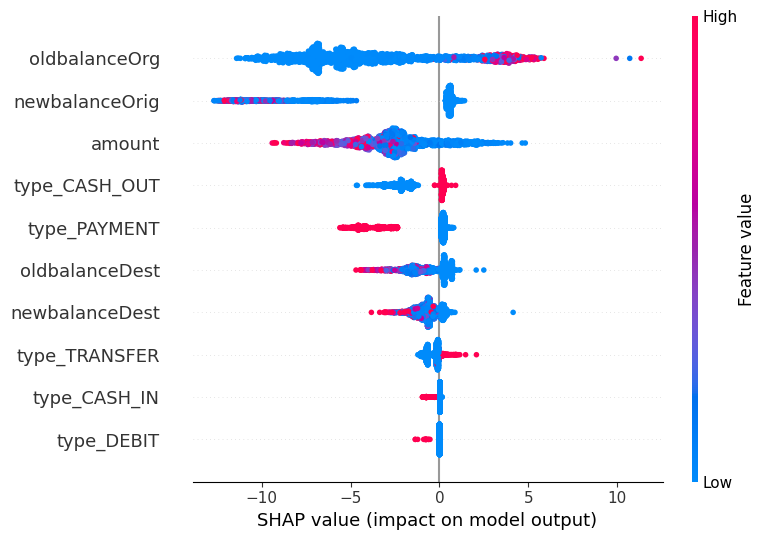

In [9]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_enc[:2000])

shap.summary_plot(shap_values, X_test_enc[:2000])

## Step 9: SHAP Local Explanation (Individual Prediction)

We explain the decision for a **single applicant**:  
- The waterfall plot shows how each feature pushed the prediction towards **high risk** or **low risk**.  
- This helps risk analysts justify decisions for individual customers.

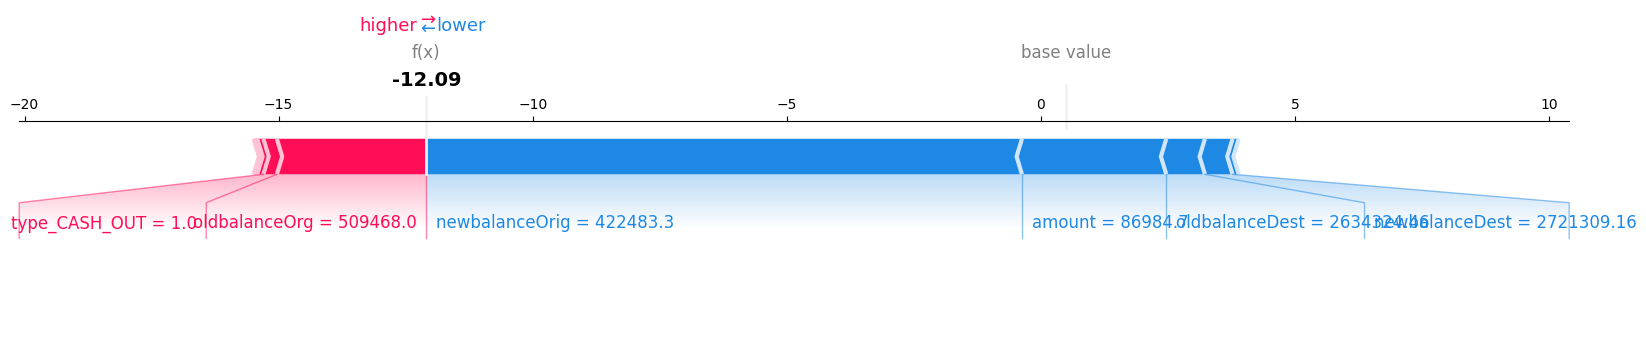

In [10]:
i = 5  # index of a transaction
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_enc.iloc[i,:], matplotlib=True
)

## Step 10: Save Trained Model

We save the trained XGBoost model and its feature list (`.pkl` files) using `joblib`.  
These files are required to build a **Streamlit app** for interactive predictions.

In [11]:
import joblib

# Save model
joblib.dump(xgb, "xgb_model.pkl")

# Save feature names
joblib.dump(list(X_train_enc.columns), "xgb_features.pkl")

['xgb_features.pkl']

# Conclusion

- Logistic Regression gave a baseline ROC-AUC of ~0.98  
- XGBoost improved performance to ~0.99, handling imbalance better  
- SHAP explainability revealed key drivers: **Interest Rate, Loan Grade, Term, DTI**  

This project demonstrates an **end-to-end ML pipeline for credit risk analysis**:  
Data prep → Modeling → Evaluation → Explainability → Deployment.